##### Copyright 2021 The OpenFermion Developers

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simulating the Fermi-Hubbard model

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/openfermion/fqe/tutorials/fermi_hubbard"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/OpenFermion/blob/master/docs/fqe/tutorials/fermi_hubbard.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/OpenFermion/blob/master/docs/fqe/tutorials/fermi_hubbard.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/OpenFermion/docs/fqe/tutorials/fermi_hubbard.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

This notebook shows how to simulate the one-dimensional Fermi-Hubbard Hamiltonian

$$
H = - J \sum_{j = 1}^{L - 1} \sum_{\sigma \in \{ \uparrow, \downarrow \}} c_{j, \sigma}^\dagger c_{j + 1, \sigma} + \text{h.c.} + U \sum_{j} n_{j\uparrow} n_{j\downarrow}
$$

using FQE. Here $j = 1, ..., L$ denotes site/orbital and $\sigma \in \{ \uparrow, \downarrow \}$ denotes spin. By the end of the tutorial, we reproduce plots from the [Fermi-Hubbard experiment paper](https://arxiv.org/abs/2010.07965) and the corresponding [ReCirq tutorial](https://quantumai.google/cirq/experiments/fermi_hubbard/experiment_example).

In [2]:
try:
    import fqe
except ImportError:
    # TODO: Change to `pip install fqe --quiet` when FQE>0.1.0 is released.
    !pip install git+https://github.com/quantumlib/OpenFermion-FQE --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [3]:
import copy
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from scipy.linalg import expm

import openfermion as of
import fqe

## Defining the Hamiltonian

We first define the Fermi-Hubbard Hamiltonian using OpenFermion.

In [4]:
"""Define the Hamiltonian."""
# Parameters.
nsites = 4
U = 2.0
J = -1.0

hubbard = of.fermi_hubbard(1, nsites, tunneling=-J, coulomb=U, periodic=False)

## Time evolution

In this section we show how to do time evolution with FQE. We start from a random initial state in the two-particle $S_z = 0$ sector to ignore the details of state preparation in the [Fermi-Hubbard experiment paper](https://arxiv.org/abs/2010.07965) for now.

In [5]:
nele, sz = 2, 0
init_wfn = fqe.Wavefunction([[nele, sz, nsites]])
init_wfn.set_wfn(strategy="random")

To do the time evolution, we can simply call the `fqe.Wavefunction.time_evolve` method with the Hubbard Hamiltonian and evolution time. When passing `time_evolve` a general fermion operator, FQE converts this into a dense Hamiltonian for time evolution. The evolution is accomplished by a Taylor expansion method.


In [6]:
%%time
e_time = 0.9
true_evolved_fqe = init_wfn.time_evolve(e_time, hubbard)

CPU times: user 598 ms, sys: 22.7 ms, total: 620 ms
Wall time: 22.3 ms


We can compare the speed of this method to direct matrix exponentiation as follows.

In [7]:
%%time
# Convert FQE wavefunction to an 2^n vector |𝛹⟩.
init_cirq_wfn = fqe.to_cirq(init_wfn)

# Exponentiate the (sparse) Hamiltonian U = exp(-i H t).
unitary = expm(-1j * e_time * of.get_sparse_operator(hubbard).todense())

# Do the time evolution |𝛹'⟩ = U |𝛹⟩.
true_evolved_cirq = unitary @ init_cirq_wfn

CPU times: user 5.65 s, sys: 1.63 s, total: 7.29 s
Wall time: 252 ms


The next cell verifies both methods produce the same final wavefunction.

In [8]:
fidelity = abs(fqe.vdot(true_evolved_fqe, fqe.from_cirq(true_evolved_cirq, thresh=1e-12)))**2
assert np.isclose(fidelity, 1.0)

Even for a small number of sites, the FQE simulation is notably faster than the direct matrix exponentian simulation. This is because FQE evolves in only fixed particle and spin subspace and because the time evolution is simulated by series expansion of the matrix exponent. 

### Trotterization

We can apply the Trotter formula and evolve the hopping Hamiltonian (one-body terms)

$$
H_{\text{hop}} := - J \sum_{j = 1}^{L - 1} \sum_{\sigma \in \{ \uparrow, \downarrow \}} c_{j, \sigma}^\dagger c_{j + 1, \sigma} + \text{h.c.} 
$$

and the charge-charge interaction (two-body terms)

$$
H_{\text{cc}} := U \sum_{j} n_{j\uparrow} n_{j\downarrow}
$$

separately for short time steps. We first split up the Hamiltonian into one-body and two-body terms.

In [9]:
# Each site has two spins.
nqubits = 2 * nsites

# One-body (hopping) terms.
one_body_terms = [
    op + of.hermitian_conjugated(op) for op in (
        of.FermionOperator(((i, 1), (i + 2, 0)), coefficient=J) for i in range(nqubits - 2)
    )
]

# Two-body (charge-charge) terms.
two_body_terms = [
    of.FermionOperator(((i, 1), (i, 0), (i + 1, 1), (i + 1, 0)), coefficient=U)
    for i in range(0, nqubits, 2)
]

# Verify this produces the same Hamiltonian from OpenFermion.
assert sum(one_body_terms) + sum(two_body_terms) == hubbard

The Hopping Hamiltonian is a $2^n \times 2^n$ matrix, so one method for time evolution is directly exponentiating this matrix to apply $e^{- i t H_{\text{hop}}}$ to the initial state.

In [10]:
# Get the 2^n x 2^n matrix (as a sparse operator).
sparse_hopping_matrix = of.get_sparse_operator(sum(one_body_terms))

# Exponentiate the matrix.
unitary = expm(-1j * e_time * sparse_hopping_matrix.todense())

# Time-evolve the initial state.
evolved_cirq_wfn = unitary @ init_cirq_wfn

Now let's see how to do this in FQE. We first recognize the hopping Hamiltonian can be written as the following $n \times n$ matrix.

In [11]:
hopping_matrix = J * (np.diag([1] * (nsites - 1), k=1) + np.diag([1] * (nsites - 1), k=-1))
print(hopping_matrix)

[[-0. -1. -0. -0.]
 [-1. -0. -1. -0.]
 [-0. -1. -0. -1.]
 [-0. -0. -1. -0.]]


Using the unitary generated by this matrix, we can evolve the initial state using the function `evolve_fqe_givens` as shown below.

In [12]:
from fqe.algorithm.low_rank import evolve_fqe_givens

umat = expm(-1j * e_time * hopping_matrix)
evolved_wfn = evolve_fqe_givens(init_wfn, umat)

We can verify the wavefunction evolved by FQE and the wavefunction evolved by direct matrix exponentiation are identical.

In [13]:
fidelity = abs(fqe.vdot(evolved_wfn, fqe.from_cirq(evolved_cirq_wfn, thresh=1e-6)))**2
assert np.isclose(fidelity, 1.0)

Like the Hopping Hamiltonian, the charge-charge interaction is a $2^n \times 2^n$ matrix, so we can again apply $e^{- i t H_{\text{cc}}}$ to the initial state.

In [14]:
# Get the 2^n x 2^n matrix (as a sparse operator).
sparse_charge_charge_matrix = of.get_sparse_operator(sum(two_body_terms))

# Exponentiate the matrix.
unitary = expm(-1j * e_time * sparse_charge_charge_matrix.todense())

# Time-evolve the initial state.
evolved_cirq_wfn = unitary @ init_cirq_wfn

As with the hopping Hamiltonian, the charge-charge term can be written as an $n \times n$ matrix as follows.

In [15]:
charge_charge_matrix = np.diag([U] * nsites)
charge_charge_matrix

array([[2., 0., 0., 0.],
       [0., 2., 0., 0.],
       [0., 0., 2., 0.],
       [0., 0., 0., 2.]])

We use this to perform time-evolution with the `evolve_fqe_charge_charge_alpha_beta` function. This function applies

$$
\exp\left(-i t \sum_{i,j} v_{i, j} n_{i, \alpha} n_{j, \beta} \right)
$$

for any coefficients $v_{i, j}$ to the wavefunction. (One can easiliy check the charge-charge interaction $H_{\text{cc}}$ can be written in this way.)

In [16]:
from fqe.algorithm.low_rank import evolve_fqe_charge_charge_alpha_beta

evolved_fqe_wfn = evolve_fqe_charge_charge_alpha_beta(
    init_wfn, 
    charge_charge_matrix, 
    e_time
)

As before we can verify this produces the same evolved wavefunction as direct matrix exponentiation.

In [17]:
fidelity = abs(fqe.vdot(evolved_fqe_wfn, fqe.from_cirq(evolved_cirq_wfn, thresh=1e-6)))**2
assert np.isclose(fidelity, 1.0)

At this point we can simulate a specified number of Trotter steps as follows.

In [18]:
# Set the number of Trotter steps.
trotter_steps = 10

# Evolution under the hopping Hamiltonian for a single Trotter step.
umat = expm(-1j * hopping_matrix * (e_time / trotter_steps))

# Simulate each Trotter step.
current_wfn = copy.deepcopy(init_wfn)
for _ in range(trotter_steps):
    # Evolve the Hopping Hamiltonian.
    current_wfn = evolve_fqe_givens(current_wfn,  u=umat)

    # Evolve the charge-charge interaction.
    current_wfn = evolve_fqe_charge_charge_alpha_beta(
        current_wfn, 
        charge_charge_matrix, 
        e_time / trotter_steps,
    )

Since we already evolved the wavefunction without Trotterization, we can compare the Trotterized evolution to this below.

In [19]:
trotterized_fidelity = abs(fqe.vdot(true_evolved_fqe, current_wfn))**2
print("Trotterized fidelity:", trotterized_fidelity)

Trotterized fidelity: 0.9984235753894126


One can increase the number of Trotter steps to increase this fidelity. When reproducing experimental results below, we will use Trotterization as in the paper.

## Reproducing experimental results


We now reproduce results from the [Fermi-Hubbard experiment paper](https://arxiv.org/abs/2010.07965) using the time-evolution methods in FQE we have discussed above. The only remaining ingredient is the initial state.

### Preparing the initial state

The initial state in the Fermi-Hubbard experiment is the ground state of a non-interacting Hamiltonian with different onsite potentials. The spin-up sector and spin-down sector have no coupling. We create the two non-interacting components of this Hamiltonian below.

In [20]:
# Parameters used in the Fermi-Hubbard experiment.
nsites = 8
l_up = 4
m_up = 4.5
sigma_up = 1

# For convenience.
site_index = np.arange(1, nsites + 1)

# Creating the spin-up and spin-down Hamiltonians.
spin_up_ham = np.diag([-1.] * (nsites - 1), k=1) + np.diag([-1.] * (nsites - 1), k=-1)
spin_up_ham += np.diag(-l_up * np.exp(-0.5 * (site_index - m_up)**2) / sigma_up**2)
spin_down_ham = np.diag([-1.] * (nsites - 1), k=1) + np.diag([-1.] * (nsites - 1), k=-1)

We know our one-body Hamiltonian is diagonalized by a quadratic Hamiltonian that can be implemented via a Givens rotation network. We now occupy the two lowest states $b^\dagger_{1a} b^\dagger_{2a} b^\dagger_{1b} b^\dagger_{2b}|\text{vac}\rangle$ and then reverse-transform back to the original basis. 

In [21]:
# Initialize wavefunction to occupy the two lowest states.
init_wfn = fqe.Wavefunction([[nsites // 2, 0, nsites]])
init_wfn.set_wfn(strategy='hartree-fock')
init_wfn.print_wfn()

Sector N = 4 : S_z = 0
a'00000011'b'00000011' (1+0j)


To transform back, we first diagonalize the spin-up and spin-down hamiltonians to get the eigenbasis.

In [22]:
_, v_up = np.linalg.eigh(spin_up_ham)
_, v_down = np.linalg.eigh(spin_down_ham)

And now rotate back to the original basis through a one-body transform implemented with the Givens rotation network.

In [23]:
from fqe.algorithm.low_rank import evolve_fqe_givens_sector


init_wfn = evolve_fqe_givens_sector(init_wfn, v_up, sector='alpha')
init_wfn = evolve_fqe_givens_sector(init_wfn, v_down, sector='beta')

Now that we have the initial state, we can compute the charge ($+$) and spin ($-$) density, respectively

$$
\rho_{j}^{\pm} = \langle n_{j, \uparrow} \rangle \pm \langle n_{j, \downarrow} \rangle,
$$

at time $t = 0$.

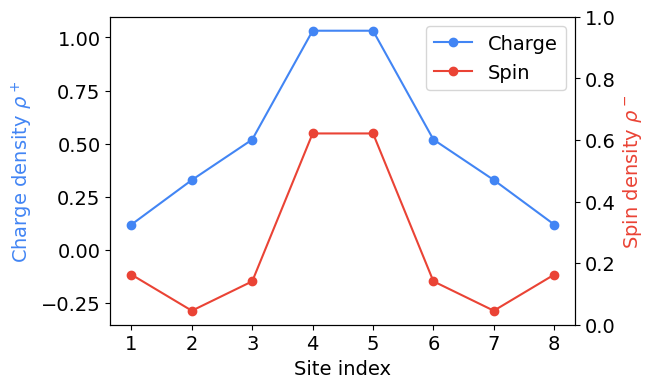

In [24]:
#@title Plotting.
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 14
colors = ['#4285F4', '#EA4335']

# Plot the data.
opdm_a, opdm_b = init_wfn.sector((nsites // 2, 0)).get_spin_opdm()
charge_density = np.diagonal(opdm_a).real + np.diagonal(opdm_b).real
spin_density = np.diagonal(opdm_a).real - np.diagonal(opdm_b).real

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
plt.plot(site_index, charge_density, "-o", color=colors[0], label="Charge")
plt.plot(site_index, spin_density, "-o", color=colors[1], label="Spin")

# Axes.
ax.set_ylabel(r"Charge density $\rho^+$", color=colors[0])
ax_twin = ax.twinx()
ax_twin.set_ylabel(r"Spin density $\rho^-$", color=colors[1])

ax.set_xticks(site_index)
ax.set_xlabel("Site index")
ax.legend();

One can check this plot reproduces Fig. 2(a) from the [Fermi-Hubbard experiment paper](https://arxiv.org/abs/2010.07965). 

#### Compare to direct diagonalization

Here we quickly compare our previous procedure for creating the initial state to exact diagonalization. We will see they are identical.

The cell below creates the initial non-interacting Hamiltonian to diagonalize in two steps.

In [25]:
# (1) Create Fermion operator.
h0 = np.zeros((2 * nsites, 2 * nsites))
h0[::2, ::2] = spin_up_ham
h0[1::2, 1::2] = spin_down_ham

fop = of.FermionOperator()
for p, q in product(range(2 * nsites), repeat=2):
    fop += of.FermionOperator(((p, 1), (q, 0)), coefficient=h0[p, q])

fop_mat = of.get_sparse_operator(fop)

# (2) Project Fermion operator.
dim = 2**(2 * nsites)
diag_val = []
diag_pos = []

for ii in range(dim):
    ket = np.binary_repr(ii, width=2*nsites)
    ket_a = list(map(int, ket[::2]))
    ket_b = list(map(int, ket[1::2]))

    if np.isclose(sum(ket_a) + sum(ket_b), 4) and np.isclose(sum(ket_a) - sum(ket_b), 0):
        assert np.isclose(sum(ket_a), 2)
        assert np.isclose(sum(ket_b), 2)
        diag_val.append(1)
        diag_pos.append(ii)


proj_n = sparse.coo_matrix((diag_val, (diag_pos, diag_pos)), shape=(dim, dim))
fop_mat = proj_n @ fop_mat @ proj_n  # Hamiltonian to diagonalize.

Now that we have the Hamiltonian, we can diagonalize it to get the ground state.

In [26]:
evals, evecs = sparse.linalg.eigsh(fop_mat.real, k=1)

At this point we have the initial wavefunction as a $2^n$ element vector. Below we convert this to the FQE representation and check it is identical to the previous initial wavefunction we prepared.

In [27]:
init_wfn_from_diag = fqe.from_cirq(evecs[:, 0].flatten(), thresh=1.0E-12)

# Check.
fidelity = abs(fqe.vdot(init_wfn, init_wfn_from_diag)) ** 2
assert np.isclose(fidelity, 1.0)

### Computing the time-evolved charge and spin density

We now time-evolve the initial state under the Fermi-Hubbard model. As in the paper, we use time step $\tau = 0.3 \hbar / J$ for a total simulation time of $16.5 \hbar / J$. (Note that we use atomic units where $\hbar = 1$.)

In [28]:
# Set the time step and number of Trotter steps (using hbar = 1).
dt = 0.3 
trotter_steps = 55

hopping_u = expm(-1j * dt * spin_down_ham)
charge_u = np.diag([U] * nsites)

opdms_alpha = [opdm_a]
opdms_beta = [opdm_b]
real_times = [0.0]

current_time = 0.0
final_wfn = init_wfn
for tt in range(trotter_steps):
    final_wfn = evolve_fqe_givens(final_wfn, hopping_u)
    final_wfn = evolve_fqe_charge_charge_alpha_beta(final_wfn, charge_u, dt)
    current_time += dt
    opdm_a_current, opdm_b_current = final_wfn.sector((nsites // 2, 0)).get_spin_opdm()

    # Store the opdms at each time step.
    opdms_alpha.append(opdm_a_current)
    opdms_beta.append(opdm_b_current)
    real_times.append(current_time)

Using the stored data, we compute the charge and spin density at various times below.

In [29]:
# Times to plot the charge & spin density at.
times = [0.0, 1.2, 1.8, 3.0]
time_indices = [int(t / dt) for t in times]

charge_densities = []
spin_densities = []
for idx in time_indices:
    charge_densities.append(np.diagonal(opdms_alpha[idx] + opdms_beta[idx]).real)
    spin_densities.append(np.diagonal(opdms_alpha[idx] - opdms_beta[idx]).real)

 We now plot these values to reproduce Fig. 1(a) from the Fermi-Hubbard paper.

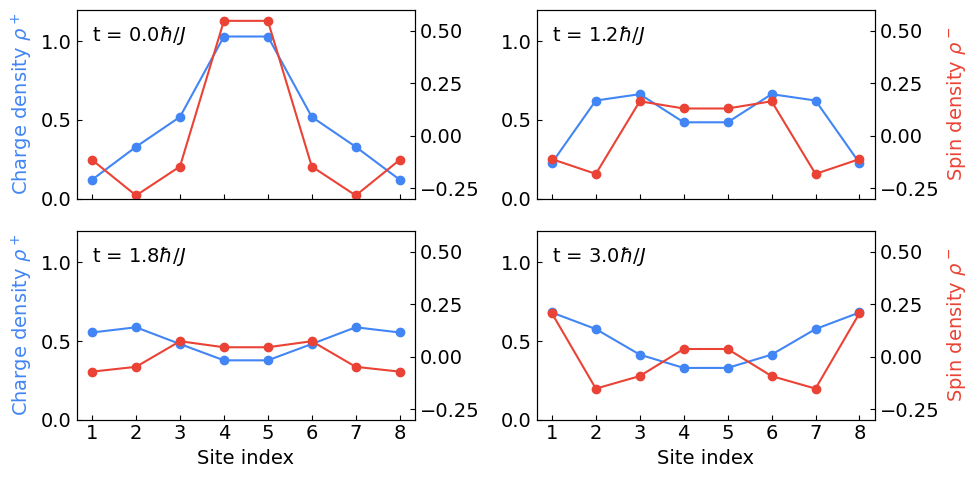

In [30]:
#@title Plotting.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5), sharex=True)

for (i, ax) in enumerate(axes.flatten()):
    ax.plot(site_index, charge_densities[i], "-o", color=colors[0])
    ax_twin = ax.twinx()
    ax_twin.plot(site_index, spin_densities[i], "-o", color=colors[1])

    ax.set_ylim([0, 1.2])
    ax_twin.set_ylim([-0.3, 0.6])
    ax.tick_params(which="both", direction="in")
    ax_twin.tick_params(which="both", direction="in")

    if i >= 2:
        ax.set_xlabel("Site index")
    if i % 2 == 0:
        ax.set_ylabel(r"Charge density $\rho^+$", color=colors[0])
    if i % 2 == 1:
        ax_twin.set_ylabel(r"Spin density $\rho^-$", color=colors[1])
    ax.text(1, 1, rf"t = ${times[i]} \hbar / J$")

plt.xticks(site_index)
plt.tight_layout()
plt.show();

### Computing the charge and spin spread

Last, we use this data to compute the charge and spin spread.

In [31]:
charge_spread = []
spin_spread = []
spread_func = np.abs(np.arange(1, nsites + 1) - (nsites + 1) / 2)

for ii in range(len(opdms_alpha)):
    charge_spread.append(np.sum(np.multiply(spread_func, np.diagonal(opdms_alpha[ii] + opdms_beta[ii]).real)))
    spin_spread.append(np.sum(np.multiply(spread_func, np.diagonal(opdms_alpha[ii] - opdms_beta[ii]).real)))

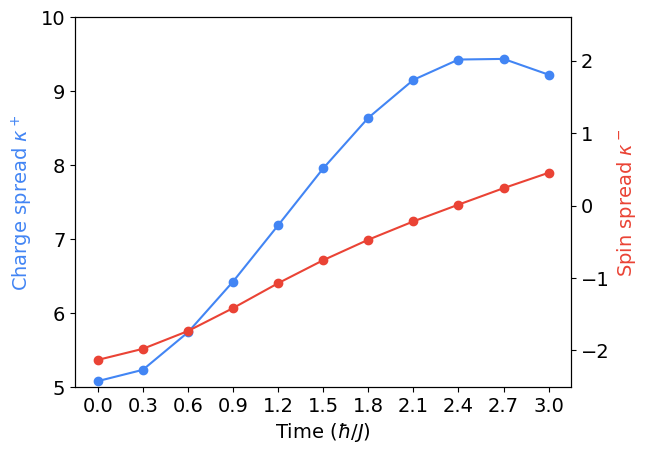

In [32]:
#@title Plotting.
fig, ax = plt.subplots(nrows=1, ncols=1)

stop = 11
ax.plot(real_times[:stop], charge_spread[:stop], "-o", color=colors[0])
axtwin = ax.twinx()
axtwin.plot(real_times[:stop], spin_spread[:stop], "-o", color=colors[1])

ax.set_ylim([5, 10])
axtwin.set_ylim([-2.5, 2.6]);

ax.set_xticks(real_times[:stop])

ax.set_xlabel(r"Time $(\hbar / J)$")
ax.set_ylabel(r"Charge spread $\kappa^+$", color=colors[0])
axtwin.set_ylabel(r"Spin spread $\kappa^-$", color=colors[1]);

One can check this reproduces the $u = 0$ subplot from Fig. 2(b) in the Fermi-Hubbard paper.